In [1]:
# install.packages("h2o", type="source", repos=(c("http://h2o-release.s3.amazonaws.com/h2o/latest_stable_R")))

In [2]:
getwd()

[1] "/home/m/repo/ml-recipes/jupyter"

In [3]:
renv::activate()

In [4]:
# renv::install("rsample")
# renv::install("vctrs")
# renv::install("h2o")
# renv::install("data.table")
# renv::install("ggplot2")
# renv::install("bit64")
# renv::snapshot()

In [5]:
renv::restore()

* The library is already synchronized with the lockfile.


In [6]:
library(h2o)
library(data.table)
library(rsample)
library(vctrs)
library(ggplot2)
library(bit64)
library(languageserver)

packageVersion("h2o")


----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit https://docs.h2o.ai

----------------------------------------------------------------------



Attaching package: ‘h2o’


The following objects are masked from ‘package:stats’:

    cor, sd, var


The following objects are masked from ‘package:base’:

    &&, %*%, %in%, ||, apply, as.factor, as.numeric, colnames,
    colnames<-, ifelse, is.character, is.factor, is.numeric, log,
    log10, log1p, log2, round, signif, trunc



Attaching package: ‘data.table’


The following objects are masked from ‘package:h2o’:

    hour, month, week, year


Loading required package: bit


Attaching package: ‘bit’


The following object is masked from ‘package:data.table’:

    setattr


The following object is masked from ‘package

[1] ‘3.40.0.1’

In [7]:
renv::snapshot()

* Lockfile written to '~/repo/ml-recipes/jupyter/renv.lock'.


In [8]:
# h2o.shutdown()

In [9]:
# sessionInfo()

In [10]:
h2o.init(ip = 'localhost', port = 54321, nthreads= -1, max_mem_size = '4g')


H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    /tmp/RtmpV2LKP2/file8bae69de9e3a/h2o_m_started_from_r.out
    /tmp/RtmpV2LKP2/file8bae3ddd2cc7/h2o_m_started_from_r.err


Starting H2O JVM and connecting: .. Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         1 seconds 356 milliseconds 
    H2O cluster timezone:       Europe/Prague 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.40.0.1 
    H2O cluster version age:    2 months and 8 days 
    H2O cluster name:           H2O_started_from_R_m_fth430 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   4.00 GB 
    H2O cluster total cores:    12 
    H2O cluster allowed cores:  12 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    R Version:                  

In [11]:
random_seed = 17

In [12]:
source("features.R")

feature_col = c(red, blue)
target = c("WINNER")

all <- fread(file = "data/mma.csv")

all[,(target) := lapply(.SD, as.logical), .SDcols=target]
all[,y := ifelse(WINNER, "RED", "BLUE")]
all[,y := as.factor(y)]
# all[,y]

In [13]:
selected <- subset(all, select = c(feature_col, target, 'y'))
# selected <- all[, ..(feature_col, target)]

# colnames(selected)
# lapply(selected, class)
head(selected[,y], 5)

[1] RED RED RED RED RED
Levels: BLUE RED

In [14]:
#Code
set.seed(random_seed)
split_strat <- initial_split(selected, prop = 0.8,
                             strata = 'y')
train <- training(split_strat)
test <- testing(split_strat)

In [15]:
table(test[,y])


BLUE  RED 
 286  382 

In [16]:
# Identify predictors and response
x <- feature_col
feature_col

[1] "R_AGE"           "R_HEIGHT"        "R_WEIGHT"        "R_REACH"        
 [5] "R_WIN_PCT"       "R_WIN_STREAK"    "R_LOSS_STREAK"   "R_KD"           
 [9] "R_SIG_STR"       "R_SIG_STR_ATT"   "R_TOTAL_STR"     "R_TOTAL_STR_ATT"
[13] "R_TD"            "R_TD_ATT"        "R_SUB_ATT"       "R_REV"          
[17] "R_CTRL"          "R_HEAD"          "R_HEAD_ATT"      "R_BODY"         
[21] "R_BODY_ATT"      "R_LEG"           "R_LEG_ATT"       "R_DISTANCE"     
[25] "R_DISTANCE_ATT"  "R_CLINCH"        "R_CLINCH_ATT"    "R_GROUND"       
[29] "R_GROUND_ATT"    "B_AGE"           "B_HEIGHT"        "B_WEIGHT"       
[33] "B_REACH"         "B_WIN_PCT"       "B_WIN_STREAK"    "B_LOSS_STREAK"  
[37] "B_KD"            "B_SIG_STR"       "B_SIG_STR_ATT"   "B_TOTAL_STR"    
[41] "B_TOTAL_STR_ATT" "B_TD"            "B_TD_ATT"        "B_SUB_ATT"      
[45] "B_REV"           "B_CTRL"          "B_HEAD"          "B_HEAD_ATT"     
[49] "B_BODY"          "B_BODY_ATT"      "B_LEG"           "B_LEG_ATT"      
[53] "B_DISTANCE"      "B_DISTANCE_ATT"  "B_CLINCH"        "B_CLINCH_ATT"   
[57] "B_GROUND"        "B_GROUND_ATT"

In [17]:
train_h2o <- as.h2o(train)
test_h2o <- as.h2o(test)

  |======================================================================| 100%
  |======================================================================| 100%


In [18]:
algos = c(
    'GLM', 
    'DRF', 
    'XGBoost',
    'GBM',
    'StackedEnsemble'
    # 'DeepLearning'
    )

max_models = 20

# Run AutoML for 20 base models
aml <- h2o.automl(x = x, 
                  y = 'y',
                  sort_metric = 'Logloss',
                  stopping_metric = 'Logloss',
                  training_frame = train_h2o,
                  max_models = max_models,
                  seed = random_seed,
                  include_algos=algos,
                  nfolds=-1,
                  # balance_classes=T #Note this one ruins the validation loss plot 
                 )

# View the AutoML Leaderboard
lb <- aml@leaderboard

  |======================================================================| 100%


In [19]:
lb <- h2o.get_leaderboard(object = aml, extra_columns = "ALL")
as.data.table(lb)

model_id,logloss,auc,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<chr>
StackedEnsemble_AllModels_1_AutoML_1_20230417_174828,0.6601040,0.6198692,0.6857534,0.4935327,0.4838901,0.2341496,1094,0.033424,StackedEnsemble
StackedEnsemble_BestOfFamily_1_AutoML_1_20230417_174828,0.6607649,0.6174939,0.6838906,0.4963835,0.4842126,0.2344618,997,0.030449,StackedEnsemble
GLM_1_AutoML_1_20230417_174828,0.6612126,0.6174282,0.6837703,0.4969276,0.4844649,0.2347062,143,0.003440,GLM
GBM_1_AutoML_1_20230417_174828,0.6641089,0.6108711,0.6698753,0.4969325,0.4857120,0.2359162,1107,0.007535,GBM
GBM_grid_1_AutoML_1_20230417_174828_model_2,0.6641661,0.6100868,0.6753205,0.4911055,0.4857623,0.2359650,105,0.006524,GBM
GBM_grid_1_AutoML_1_20230417_174828_model_1,0.6679364,0.6011337,0.6656560,0.4994510,0.4875835,0.2377377,101,0.007088,GBM
GBM_2_AutoML_1_20230417_174828,0.6742156,0.5908835,0.6562880,0.4984638,0.4905447,0.2406341,214,0.011301,GBM
XGBoost_grid_1_AutoML_1_20230417_174828_model_5,0.6749553,0.5945522,0.6557787,0.4908839,0.4906872,0.2407740,1256,0.007004,XGBoost
DRF_1_AutoML_1_20230417_174828,0.6760201,0.5898461,0.6585240,0.5000000,0.4913474,0.2414222,694,0.018719,DRF


In [20]:
pred <- h2o.predict(aml@leader, test_h2o)
pred <- as.data.table(pred)
colnames(pred)

  |======================================================================| 100%


[1] "predict" "BLUE"    "RED"

In [21]:
res <- data.table(
    truth = test[,y],
    pred = pred[,predict],
    prob = pred[,RED]
    )

head(res)

truth,pred,prob
<fct>,<fct>,<dbl>
RED,RED,0.6081660
BLUE,RED,0.5467455
RED,RED,0.7044309
RED,RED,0.7090387
BLUE,RED,0.5910020
BLUE,RED,0.4612723


In [22]:
aml@leader

Model Details:

H2OBinomialModel: stackedensemble
Model ID:  StackedEnsemble_AllModels_1_AutoML_1_20230417_174828 
Model Summary for Stacked Ensemble: 
                                    key            value
1                     Stacking strategy cross_validation
2  Number of base models (used / total)             5/20
3      # GBM base models (used / total)              3/8
4  # XGBoost base models (used / total)              0/9
5      # GLM base models (used / total)              1/1
6      # DRF base models (used / total)              1/2
7                 Metalearner algorithm              GLM
8    Metalearner fold assignment scheme           Random
9                    Metalearner nfolds                5
10              Metalearner fold_column               NA
11   Custom metalearner hyperparameters             None


H2OBinomialMetrics: stackedensemble
** Reported on training data. **

MSE:  0.1879666
RMSE:  0.4335512
LogLoss:  0.5624317
Mean Per-Class Error:  0.2484927
AUC:  

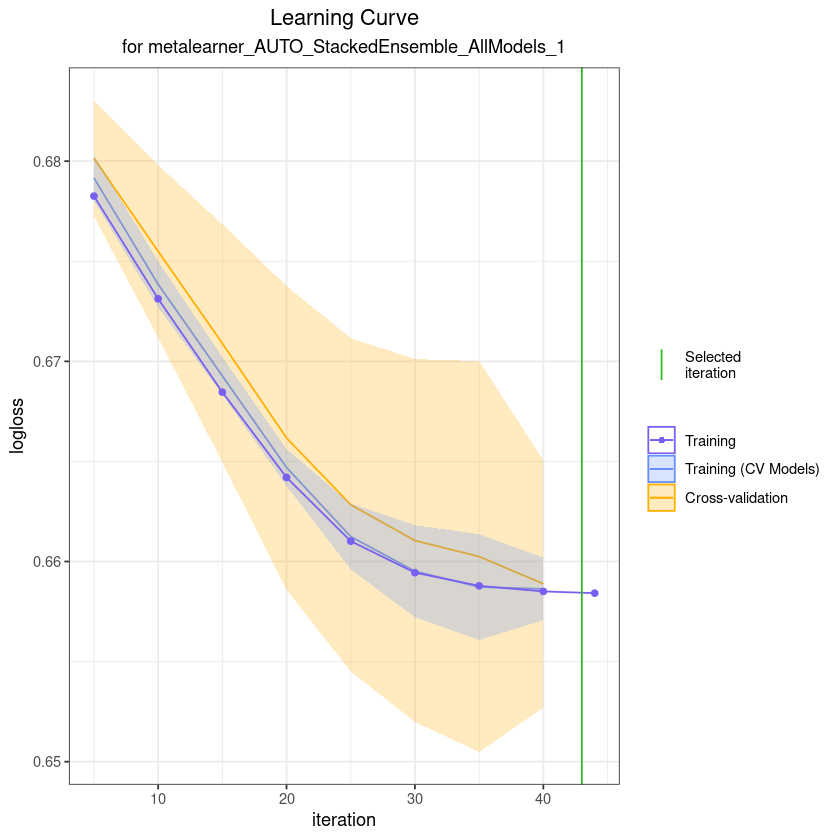

In [23]:
learning_curve_plot <- h2o.learning_curve_plot(aml@leader, metric = "logloss")
learning_curve_plot

# PDP
PDP plots show the average effect of a feature on the predicted outcome while holding all other features constant. This can help identify which features have the strongest relationship with the target variable. However, PDP plots can also hide important information about the distribution of the feature and its relationship with the target variable.

Warning message:
“The dot-dot notation (`..count..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(count)` instead.
ℹ The deprecated feature was likely used in the h2o package.
  Please report the issue at <https://h2oai.atlassian.net/projects/PUBDEV>.”


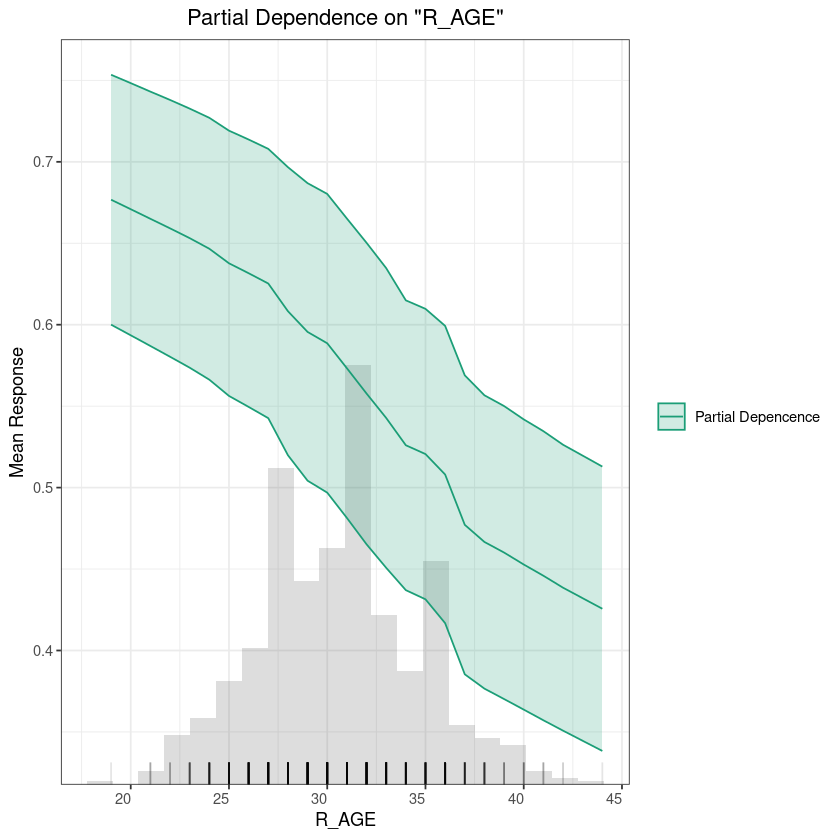

In [24]:
pd_plot <- h2o.pd_plot(aml@leader, test_h2o, "R_AGE")
pd_plot

# ICE 
 If you take the average of the lines of an ICE plot, it becomes a PDP.

ICE plots, on the other hand, show the relationship between a feature and the target variable for each individual observation. This can help identify patterns and relationships that may be hidden in the average effect shown by PDP plots. However, ICE plots can be more difficult to interpret and may not provide as clear of a picture of overall feature importance.

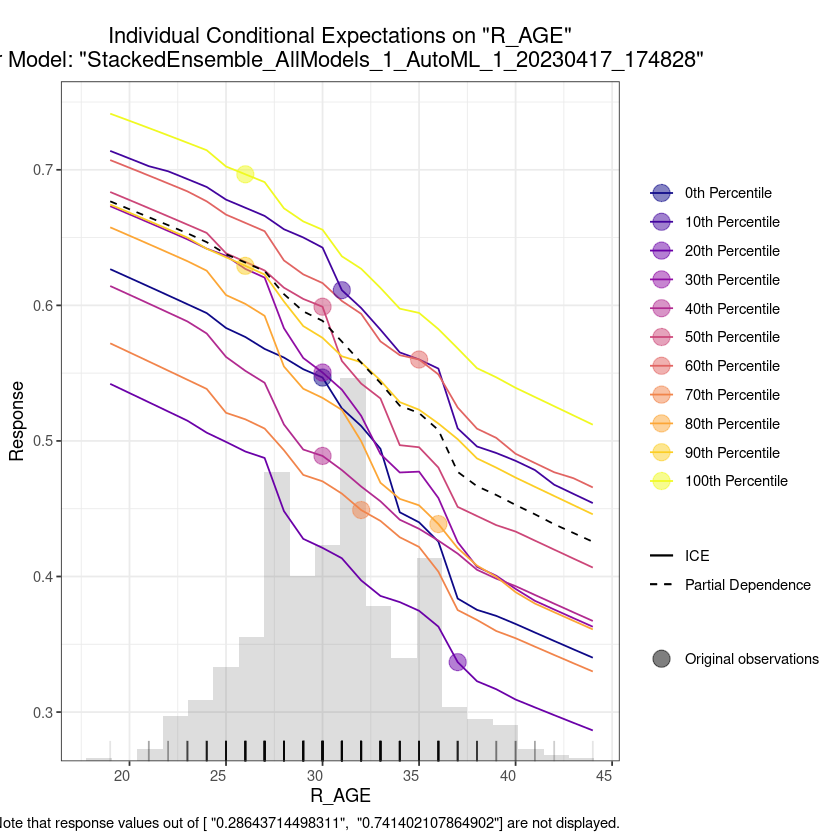

In [25]:
ice_plot <- h2o.ice_plot(aml@leader, test_h2o, "R_AGE")
ice_plot

In [26]:
glm <- h2o.get_best_model(aml, algorithm = "GLM", criterion = "logloss")
xgb <- h2o.get_best_model(aml, algorithm = "xgb", criterion = "logloss")

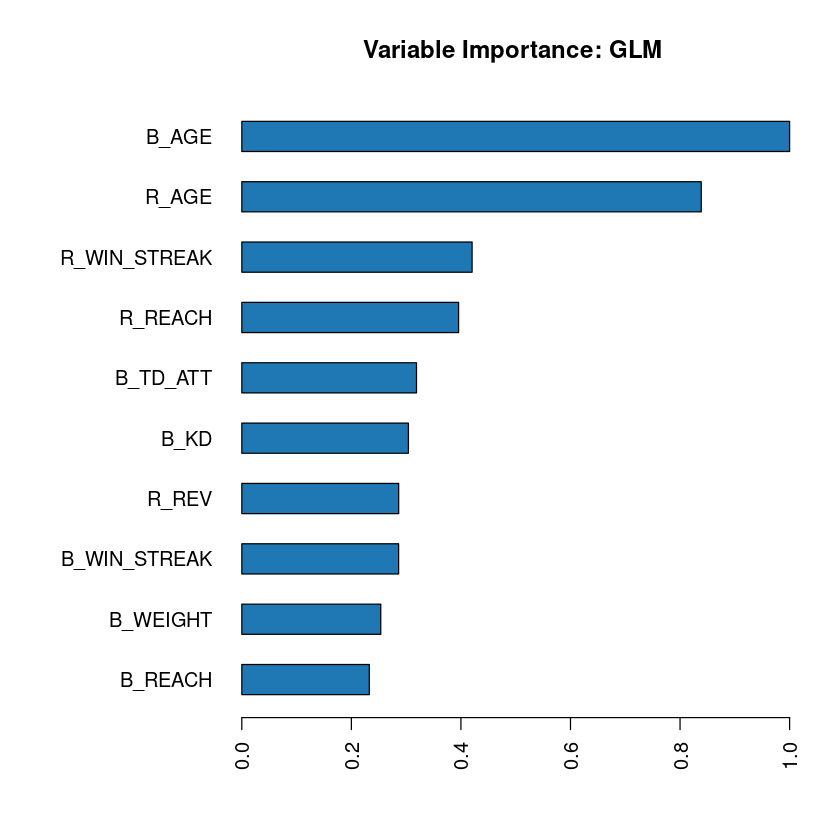

In [27]:
va_plot <- h2o.varimp_plot(glm)

# Individual SHAP
each observation gets its own set of SHAP values.

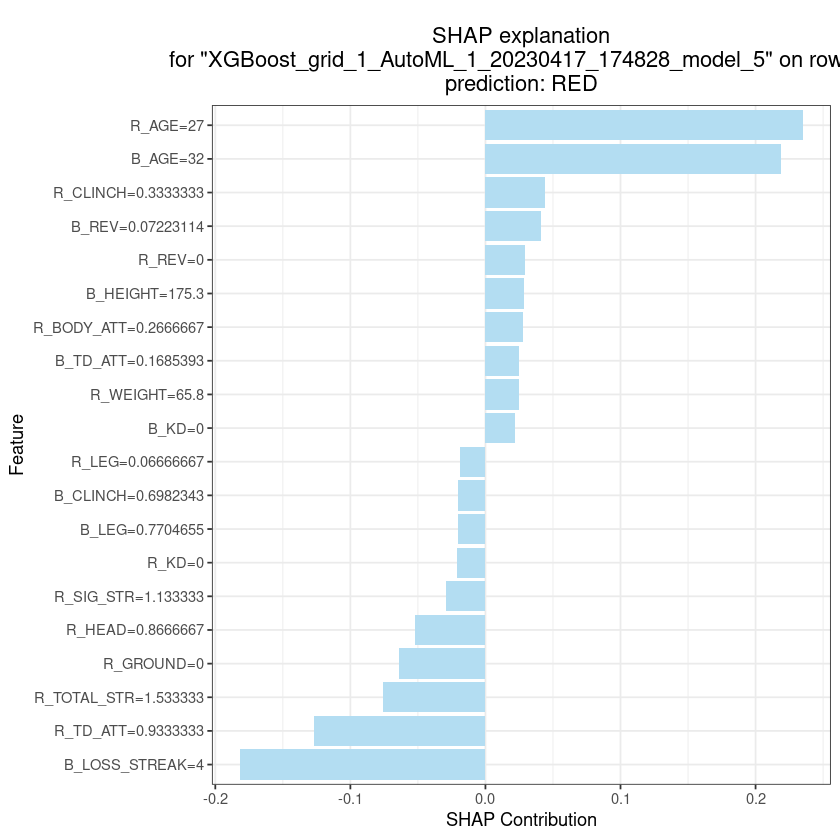

In [28]:
# HORIZONTAL location shows whether the effect of that value caused a higher or lower prediction.
shapr_plot <- h2o.shap_explain_row_plot(xgb, test_h2o, row_index = 10)
shapr_plot

# Shapley values
 The Shapley value tells us how much impact each element has on the prediction, or (more precisely) how much each feature moves the prediction away from the average prediction.
 
 Here are the steps to calculate the Shapley value for a single feature F:

- Create the set of all possible feature combinations (called coalitions)

- Calculate the average model prediction

- For each coalition, calculate the difference between the model’s prediction without F and the average prediction.

- For each coalition, calculate the difference between the model’s prediction with F and the average prediction.

- For each coalition, calculate how much F changed the model’s prediction from the average (i.e., step 4 – step 3) – this is the marginal contribution of F.

- Shapley value = the average of all the values calculated in step 5 (i.e., the average of F’s marginal contributions)

- In short, the Shapley value of a feature F is the average marginal contribution F provides the model across all possible coalitions. 

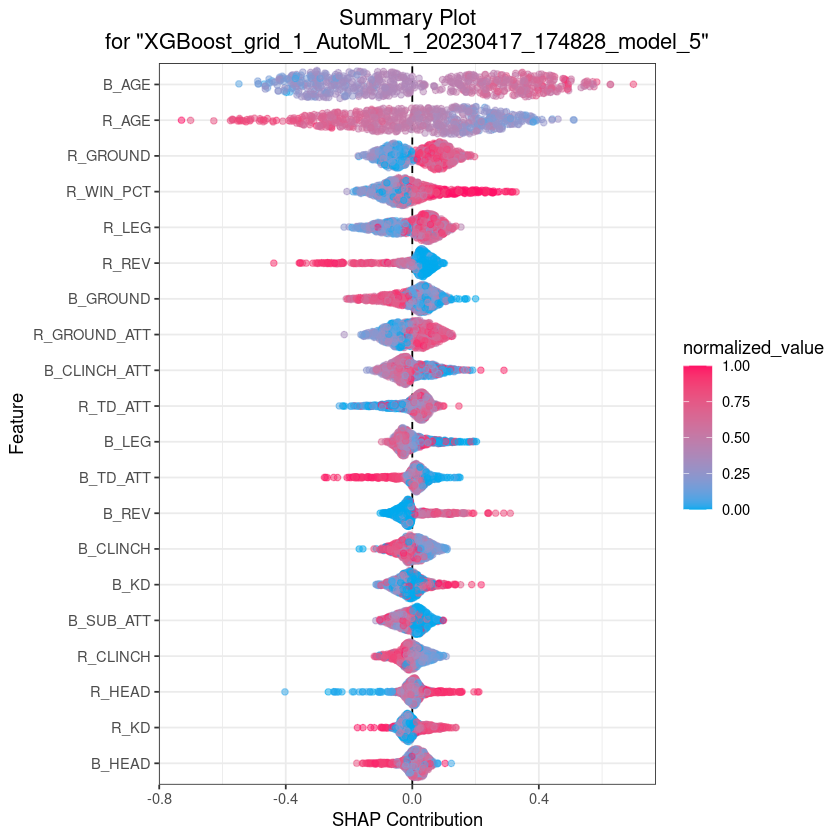

In [29]:
# VERTICAL location - Feature importance: Variables are ranked in descending order.
# RED - high #Blue low value for the dataset 
# HORIZONTAL location shows whether the effect of that value caused a higher or lower prediction.

shap_plot <- h2o.shap_summary_plot(xgb, test_h2o)
shap_plot

In [30]:
?h2o.shap_summary_plot

h2o.shap_summary_plot {h2o},R Documentation
model,"An H2O tree-based model. This includes Random Forest, GBM and XGboost only. Must be a binary classification or regression model."
newdata,"An H2O Frame, used to determine feature contributions."
columns,"List of columns or list of indices of columns to show. If specified, then the top_n_features parameter will be ignored."
top_n_features,Integer specifying the maximum number of columns to show (ranked by variable importance).
sample_size,Integer specifying the maximum number of observations to be plotted.


 ## prediction: prob of R winning 
 
 B_AGE -> higher, prediction higher 
 
 R_AGE -> higher, prediction lower
 
 B_HEAD -> head strikes by B, higher leads to lower prediction of R_WIN
 

# AUC

- When 0.5<AUC<1, there is a high chance that the classifier will be able to distinguish the positive class values from the negative ones.
- When AUC=0.5, then the classifier is not able to distinguish between Positive and Negative class points. Meaning that the classifier either predicts a random class or a constant class for all the data points.

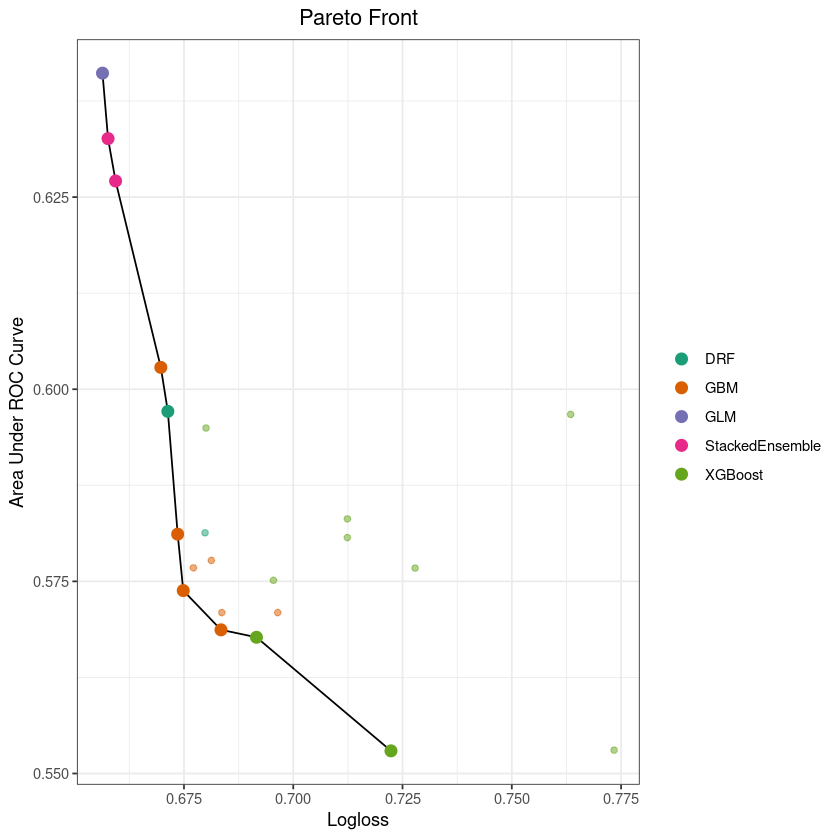

In [31]:
pf <- h2o.pareto_front(aml)
# plot(pf)
# pf@pareto_front # to retrieve the Pareto front subset of the leaderboard

combined_leaderboard <- h2o.make_leaderboard(aml, test_h2o, extra_columns = "ALL")
pf_combined <- h2o.pareto_front(combined_leaderboard, x_metric = "logloss", y_metric = "auc", optimum = "bottom left")
plot(pf_combined)
pareto_front <- pf_combined@pareto_front

In [32]:
pareto_front

,model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<chr>
1,GLM_1_AutoML_1_20230417_174828,0.6411279,0.6563564,0.6719543,0.4230220,0.4810762,0.2314343,143,0.007182,GLM
2,StackedEnsemble_BestOfFamily_1_AutoML_1_20230417_174828,0.6326108,0.6576233,0.6677649,0.4483854,0.4820641,0.2323858,997,0.027023,StackedEnsemble
3,StackedEnsemble_AllModels_1_AutoML_1_20230417_174828,0.6270961,0.6593476,0.6616083,0.4531999,0.4829227,0.2332143,1094,0.031793,StackedEnsemble
4,GBM_1_AutoML_1_20230417_174828,0.6028402,0.6697000,0.6455286,0.4658679,0.4880535,0.2381962,1107,0.012809,GBM
5,DRF_1_AutoML_1_20230417_174828,0.5971195,0.6713051,0.6596182,0.4794420,0.4890520,0.2391719,694,0.023310,DRF
10,GBM_grid_1_AutoML_1_20230417_174828_model_2,0.5811427,0.6735547,0.6165387,0.4925676,0.4900347,0.2401340,105,0.010349,GBM
16,GBM_grid_1_AutoML_1_20230417_174828_model_1,0.5738019,0.6748329,0.6176778,0.4750668,0.4907602,0.2408456,101,0.010312,GBM
19,GBM_3_AutoML_1_20230417_174828,0.5686944,0.6834708,0.6165660,0.4615018,0.4943057,0.2443382,251,0.012332,GBM
20,XGBoost_grid_1_AutoML_1_20230417_174828_model_4,0.5677242,0.6915823,0.6226735,0.4776938,0.4979943,0.2479984,147,0.007914,XGBoost


In [33]:
# Get AutoML event log
log <- aml@event_log

# Get training timing info
info <- aml@training_info

In [34]:
log

    timestamp level      stage
1 17:48:28.22  INFO   Workflow
2 17:48:28.23  INFO Validation
3 17:48:28.23  INFO Validation
4 17:48:28.24  INFO Validation
5 17:48:28.24  INFO DataImport
6 17:48:28.24  INFO DataImport
                                                                                                                                                              message
1                                                                                                                                   Project: AutoML_1_20230417_174828
2                                                                                                                               5-fold cross-validation will be used.
3                                                                             Setting stopping tolerance adaptively based on the training frame: 0.019360077316559157
4                                                                                                                      

# PDP
PDP plots show the average effect of a feature on the predicted outcome while holding all other features constant. This can help identify which features have the strongest relationship with the target variable. However, PDP plots can also hide important information about the distribution of the feature and its relationship with the target variable.

# ICE 
ICE plots, on the other hand, show the relationship between a feature and the target variable for each individual observation. This can help identify patterns and relationships that may be hidden in the average effect shown by PDP plots. However, ICE plots can be more difficult to interpret and may not provide as clear of a picture of overall feature importance.

In [35]:
# Explain first row with a single H2O model (e.g. leader model from AutoML)
# h2o.explain_row(aml@leader, test_h2o, row_index = 1)
# exm <- h2o.explain(aml@leader, test_h2o)
# exm

In [36]:
# continuous hinting

ERROR: Error in eval(expr, envir, enclos): object 'data.' not found
